# Validation
### Checking the relevance of Feature Engineering and correlation to remove unecessary variables and improve the accuracy

The aim is to create a model to predict next headway with:
* all variables
* selected variables

In [1]:
import pandas as pd
#import pandas_profiling
import numpy as np
import os
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from matplotlib import pyplot as plt
import time

In [2]:
# Choose the city of analysis

city = 'Recife'
# city = 'CG'
# city = 'Curitiba'

In [3]:
stops_ahead = 2

In [3]:
path = os.getcwd() + "/../data/output/" + city + "/notes/"

# All variables
all_data = "new_feats_data.csv"
integrated_data_path = path + all_data

In [4]:
# Reading data

df_all = pd.read_csv(integrated_data_path)

In [ ]:
df_selected = pd.read_csv(integrated_data_path)

In [5]:
rows_number = 500000 #len(df_all_data) #1000000

In [6]:
df_all = df_all.loc[0:rows_number]
# df_selected = df_selected.loc[0:rows_number]

### Converting NaN values

Changing NaN by median or:
- values of shape for gps

In [ ]:
df_all.isnull().any()

In [ ]:
# TODO removing 13 correlated variables
# df_all.drop(['DAY(alertDateTime)', 'DAY(jamUpdateDateTime)', 'MONTH(alertDateTime)', 
#                         'MONTH(jamUpdateDateTime)', 'YEAR(alertDateTime)', 'YEAR(jamUpdateDateTime)',
#                        'alertInScale', 'alertLatitude', 'alertLongitude', 'alertNThumbsUp',
#                        'alertReliability', 'jamDelay', 'jamLength'], axis=1, inplace=True)

In [7]:
# changing by shape data
df_all.gpsPointId = np.where(df_all.gpsPointId.isnull(), 0, df_all.gpsPointId)
df_all.gpsLat = np.where(df_all.gpsLat.isnull(), df_all.shapeLat, df_all.gpsLat)
df_all.gpsLon = np.where(df_all.gpsLon.isnull(), df_all.shapeLon, df_all.gpsLon)
df_all.distanceToShapePoint = np.where(df_all.distanceToShapePoint.isnull(), 
                                            0, df_all.distanceToShapePoint)


In [8]:
#grouping by weekday and filling NA's with the median of the column
numeric_feats = df_all.dtypes[(df_all.dtypes != "object") & (df_all.dtypes != "datetime64[ns]")
                               & (df_all.dtypes != "bool")].index
df_all[numeric_feats] = df_all.groupby(['WEEKDAY(gps_datetime)'])[numeric_feats].transform(lambda x: x.fillna(x.median()))

df_all.head(5)

,route,tripNum,shapeId,routeFrequency,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,...,YEAR(alertDateTime),YEAR(jamUpdateDateTime),MONTH(gps_datetime),MONTH(precipitationTime),MONTH(alertDateTime),MONTH(jamUpdateDateTime),WEEKDAY(gps_datetime),WEEKDAY(precipitationTime),WEEKDAY(alertDateTime),WEEKDAY(jamUpdateDateTime)
0,68,1,Route_160,low_frequency,12573,-8.036592,-34.975683,785.0,12021,27.0,...,2018.0,2018.0,12,12,12.0,12.0,0,0,0.0,0.0
1,68,1,Route_160,low_frequency,12581,-8.034150,-34.960756,2794.0,12021,33.0,...,2018.0,2018.0,12,12,12.0,12.0,0,0,0.0,0.0
2,68,1,Route_160,low_frequency,12582,-8.032878,-34.959775,2971.0,12021,0.0,...,2018.0,2018.0,12,12,12.0,12.0,0,0,0.0,0.0
3,68,1,Route_160,low_frequency,12583,-8.031478,-34.958622,3171.0,12021,35.0,...,2018.0,2018.0,12,12,12.0,12.0,0,0,0.0,0.0
4,68,1,Route_160,low_frequency,12589,-8.036750,-34.946086,4838.0,12021,43.0,...,2018.0,2018.0,12,12,12.0,12.0,0,0,0.0,0.0


In [ ]:
df_all.isnull().any()

In [ ]:
df_all.dtypes

### Generating dataset based on window

In [10]:
X_list = []
y_list = []
columns_df = df_all.columns

for index,line in df_all.iterrows():
    next_prediction_stop = index + stops_ahead
    if (next_prediction_stop < (len(df_all) - stops_ahead) and 
        df_all.iloc[next_prediction_stop]["DAY(gps_datetime)"] == line["DAY(gps_datetime)"] and
        df_all.iloc[next_prediction_stop]["busCode"] == line["busCode"] and
        df_all.iloc[next_prediction_stop]["nextBusCode"] == line["nextBusCode"]):
        
        X_list.append(line)
        y_list.append(df_all.iloc[next_prediction_stop]["busBunching"])

df_all_data = pd.DataFrame(X_list, columns=columns_df)
df_all_data["busBunching"] = y_list # replace the column busBunching for the N-stop-ahead label

In [ ]:
df_all_data.head(5)

In [9]:
# For w = 0
df_all_data = df_all

In [10]:
del df_all

In [11]:
# Converting categorical variables as str
df_all_data['route'] = df_all_data['route'].astype(str)
df_all_data['busCode'] = df_all_data['busCode'].astype(str)
df_all_data['stopPointId'] = df_all_data['stopPointId'].astype(str)
df_all_data['nextBusCode'] = df_all_data['nextBusCode'].astype(str)

# Converting bool to float
df_all_data.alertIsJamUnifiedAlert = df_all_data.alertIsJamUnifiedAlert.astype(np.float64)
df_all_data.alertInScale = df_all_data.alertInScale.astype(np.float64)
df_all_data.busBunching = df_all_data.busBunching.astype(np.float64)

### Converting categorical variables

In [12]:
df_all_data = pd.get_dummies(df_all_data)
df_all_data.head()

,tripNum,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,gpsPointId,gpsLat,gpsLon,distanceToShapePoint,precipitation,...,nextBusCode_12810,nextBusCode_12813,nextBusCode_12815,nextBusCode_12816,nextBusCode_12818,nextBusCode_12819,nextBusCode_12823,nextBusCode_12826,nextBusCode_12828,nextBusCode_12829
0,1,12573,-8.036592,-34.975683,785.0,27.0,-8.036673,-34.975550,17.247850,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,12581,-8.034150,-34.960756,2794.0,33.0,-8.033869,-34.960571,37.256020,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,12582,-8.032878,-34.959775,2971.0,0.0,-8.032878,-34.959775,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,12583,-8.031478,-34.958622,3171.0,35.0,-8.031753,-34.958864,40.590046,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,12589,-8.036750,-34.946086,4838.0,43.0,-8.035829,-34.947773,212.086320,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_all_data.isnull().any()

### Features Selection with PCA

It's the same thing we've done testing correlation.

In [ ]:
# y = df_all_data["busBunching"]
# df_all_data.drop('busBunching', axis=1, inplace=True)

# n_pca = PCA().fit(df_all_data)
# plt.plot(np.cumsum(n_pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

In [ ]:
# pca = PCA(10).fit(df_all_data)

In [ ]:
# Dump components relations with features:
# print pd.DataFrame(pca.components_,columns=df_all_data.columns,index = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6',
#                                                                         'PC-7','PC-8','PC-9','PC-10'])


In [ ]:
# Descriptive statistics
profile = pandas_profiling.ProfileReport(df_all_data, check_correlation=True, correlation_threshold=0.5)

In [ ]:
profile.to_file(outputfile=path + "output_after_fe_profile.html")

## Model with all variables

For headway prediction

In [ ]:
# y = df_all_data.drop('busBunching', axis=1) # with classifier produce error: asking to convert to float (doesn't make sense, it's a class)
y = df_all_data['headway']
df_all_data.drop('headway', axis=1, inplace=True)

X = df_all_data

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.5)

headway_busBunching_test = X_test_all[['headwayThreshold', 'busBunching']]
X_test_all.drop('busBunching', axis=1, inplace=True)
X_train_all.drop('busBunching', axis=1, inplace=True)

For bus bunching prediction

In [13]:
y = df_all_data['busBunching']
df_all_data.drop('busBunching', axis=1, inplace=True)
#df_all_data.drop('headway', axis=1, inplace=True)

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(df_all_data, y, test_size=0.5)

In [14]:
# function to train the model and to calculate the RMSE with cross validation
def rmse_cv(model, X_train, y_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = 10))
    return(rmse)

# function to print the coefficients of the model
def print_coefficients(model):
    w = list(model.coef_)
    # Parameters must be in reverse order because the poly function 
    w.reverse()
    print (np.poly1d(w) + model.intercept_)

# function to train the model and to return the score
def train_model(model, X_train, y_train, X_test, y_test, print_coef):
    start_time = time.time()

    model.fit(X_train, y_train)
    if (print_coef):
        print_coefficients(model)
    
    score = model.score(X_test, y_test) #how well our model is
    y_predict = model.predict(X_test)
    execution_time = time.time() - start_time
    return score, execution_time, y_predict

# function to plot the RMSE vs parameter value
def plot_rmse_param(series, param_name):
    series.plot(title = "Validation Error vs " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    
# function to get the best RMSE and the best parameter value of the model
def best_rmse_param(series):
    best_rmse = series.min()
    best_param = series.idxmin() 
    
    return(best_rmse, best_param)

def get_accuracy(y_predicted, y_real, label):
    
    if label == "headway":
        y_real['predictedBusBunching'] = y_real['headwayThreshold'].ge(y_predicted, axis=0).astype(np.float64)
        accuracy = accuracy_score(y_real['busBunching'], y_real['predictedBusBunching']) #y_true, y_pred
    else:
        accuracy = accuracy_score(y_real, y_predicted) #y_true, y_pred
    
    return accuracy

def get_fmeasure(y_predicted, y_real, label):
    
    if label == "headway":
        y_real['predictedBusBunching'] = y_real['headwayThreshold'].ge(y_predicted, axis=0).astype(np.float64)
        fmeasure = f1_score(y_real['busBunching'], y_real['predictedBusBunching']) #y_true, y_pred
    else:
        fmeasure = f1_score(y_real, y_predicted) #y_true, y_pred
                                              
    return fmeasure

def get_precision(y_predicted, y_real, label):
    
    if label == "headway":
        y_real['predictedBusBunching'] = y_real['headwayThreshold'].ge(y_predicted, axis=0).astype(np.float64)
        precision = precision_score(y_real['busBunching'], y_real['predictedBusBunching']) #y_true, y_pred
    else:
        precision = precision_score(y_real, y_predicted) #y_true, y_pred
                                              
    return precision

def get_recall(y_predicted, y_real, label):
    
    if label == "headway":
        y_real['predictedBusBunching'] = y_real['headwayThreshold'].ge(y_predicted, axis=0).astype(np.float64)
        recall = recall_score(y_real['busBunching'], y_real['predictedBusBunching']) #y_true, y_pred
    else:
        recall = recall_score(y_real, y_predicted) #y_true, y_pred
                                              
    return recall

#### Modelo RF (Random Forest)

Bad quality (better with less variables)

Random Forest é um algoritmo que ajusta várias árvores de decisão de classificação em várias subamostras do conjunto de dados e usa a média para melhorar a precisão preditiva e controlar o ajuste excessivo. A quantidade de árvores (n_estimators) é um parâmetro, cujo valor, deve ser encontrado, para que o modelo melhor represente os dados.

In [ ]:
n_estimators = [1, 10, 50, 100]
cv_rf_rmse = [rmse_cv(RandomForestRegressor(n_estimators = n, n_jobs=8), X_train_all, y_train_all).mean() 
            for n in n_estimators]

series = pd.Series(cv_rf_rmse, index = n_estimators)
plot_rmse_param(series, "n_estimators")

In [ ]:
best_rmse_rf, best_estimator_rf_all = best_rmse_param(series)

In [ ]:
n_min_samples_split = [2,3,4,5,6,7,8,9,10]
cv_rf_rmse = [rmse_cv(RandomForestRegressor(n_estimators = best_estimator_rf_all, min_samples_split = n, n_jobs=8), X_train_all, y_train_all).mean() 
            for n in n_min_samples_split]

series = pd.Series(cv_rf_rmse, index = n_min_samples_split)
plot_rmse_param(series, "n_min_samples_split")

In [ ]:
best_rmse_rf, best_split_rf = best_rmse_param(series)

In [ ]:
# best_rmse_rf, best_param_rf = best_rmse_param(series)

model_rf = RandomForestRegressor(n_estimators = best_estimator_rf_all, min_samples_split = best_split_rf, n_jobs=8)
score_rf_all, exec_time_all, y_predict_all = train_model(model_rf, X_train_all, y_train_all, X_test_all, y_test_all, 
                                      False)

In [ ]:
accuracy_rf_all = get_accuracy(y_predict_all, headway_busBunching_test, "headway")
precision_rf_all = get_precision(y_predict_all, headway_busBunching_test, "headway")
recall_rf_all = get_recall(y_predict_all, headway_busBunching_test, "headway")
fmeasure_rf_all = get_fmeasure(y_predict_all, headway_busBunching_test, "headway")

In [ ]:
# del variables

del df_all_data
del cv_rf_rmse
del series
del model_rf
del y
del X
del X_train_all
del X_test_all
del y_train_all
del y_test_all

#### Support Vector Regressor Model
It takes to long to execute

In [ ]:
# Support Vector Regressor Model - it takes to long to execute

# cs = [0.01, 1, 5, 10, 25, 50]
# cv_svr_rmse = [rmse_cv(SVR(C = c), X_train_all, y_train_all).mean() 
#             for c in cs]

# series_svr = pd.Series(cv_svr_rmse, index = cs)
# plot_rmse_param(series_svr, "C")

In [ ]:
# best_rmse_svr_all, best_param_svr_all = best_rmse_param(series_svr)

# model_svr_all = SVR(C = best_rmse_svr_all)
# score_svr_all, exec_time_svr_all = train_model(model_svr_all, False)

### Logistic Regression Model
Good quality (better with more variables)

In [ ]:
stop_criteria = [0.1, 0.01, 0.001]
cv_lr_rmse = [rmse_cv(LogisticRegression(tol = t, solver="saga"), X_train_all, y_train_all).mean() 
            for t in stop_criteria]

series = pd.Series(cv_lr_rmse, index = stop_criteria)
plot_rmse_param(series, "stop_criteria")

In [ ]:
best_rmse_lr_all, best_stop_lr_all = best_rmse_param(series)

In [ ]:
cs = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
cv_lr_rmse = [rmse_cv(LogisticRegression(tol = best_stop_lr_all, C = c, solver="saga"), X_train_all, y_train_all).mean() 
            for c in cs]

series = pd.Series(cv_lr_rmse, index = cs)
plot_rmse_param(series, "cs")

In [ ]:
best_rmse_lr_all, best_c_lr_all = best_rmse_param(series)

In [ ]:
model_lr = LogisticRegression(tol = best_stop_lr_all, C = best_c_lr_all, solver="saga")
score_lr_all, exec_time_lr_all, y_predict_lr_all = train_model(model_lr, X_train_all, y_train_all, X_test_all, y_test_all, 
                                      False)

In [ ]:
accuracy_lr_all = get_accuracy(y_predict_lr_all, y_test_all, "busBunching")
precision_lr_all = get_precision(y_predict_lr_all, y_test_all, "busBunching")
recall_lr_all = get_recall(y_predict_lr_all, y_test_all, "busBunching")
fmeasure_lr_all = get_fmeasure(y_predict_lr_all, y_test_all, "busBunching")

In [21]:
print(accuracy_lr_all)
print(precision_lr_all)
print(recall_lr_all)
print(fmeasure_lr_all)

0.852620589517642
0.0
0.0
0.0


In [30]:
y_predict_lr_all.shape

(250001,)

In [29]:
y_test_all.shape

(250001,)

### Lasso Model

In [ ]:
alphas = [0.1, 0.01, 0.001, 0.0001]
cv_lasso_rmse = [rmse_cv(Lasso(alpha = alpha, max_iter = 10000), X_train_all, y_train_all).mean() 
            for alpha in alphas]

series = pd.Series(cv_lasso_rmse, index = alphas)
plot_rmse_param(series, "alphas")

In [ ]:
best_rmse_lasso, best_alpha_lasso = best_rmse_param(series)

In [ ]:
model_lasso = Lasso(alpha = best_alpha_lasso, max_iter = 10000)
score_lasso_all, exec_time_lasso_all, y_predict_lasso_all = train_model(model_lasso, X_train_all, y_train_all, 
                                                                        X_test_all, y_test_all, False)

In [ ]:
accuracy_lasso_all = get_accuracy(y_predict_lasso_all, headway_busBunching_test, "headway")
precision_lasso_all = get_precision(y_predict_lasso_all, headway_busBunching_test, "headway")
recall_lasso_all = get_recall(y_predict_lasso_all, headway_busBunching_test, "headway")
fmeasure_lasso_all = get_fmeasure(y_predict_lasso_all, headway_busBunching_test, "headway")

In [ ]:
coef = pd.Series(model_lasso.coef_, index = X_train_all.columns)
print("Lasso choose " + str(sum(coef != 0)) + " variables and remove others " + str(sum(coef == 0)) + " variables.")

## Model with less (13) variables

- Todas as variáveis de dia, mês e ano - data do gps é suficiente
- alertInScale - alertIsJamUnifiedAlert é suficiente
- alertLat e alertLon - localização do gps é suficiente
- alertNThumbsUp e alertReliability - alertConfidence é suficiente
- jamDelay e jamLenght - jamSeverity é suficiente

In [ ]:
df_selected_data.drop(['DAY(alertDateTime)', 'DAY(jamUpdateDateTime)', 'MONTH(alertDateTime)', 
                        'MONTH(jamUpdateDateTime)', 'YEAR(alertDateTime)', 'YEAR(jamUpdateDateTime)',
                       'alertInScale', 'alertLatitude', 'alertLongitude', 'alertNThumbsUp',
                       'alertReliability', 'jamDelay', 'jamLength'], axis=1, inplace=True)

Test with 50% of the variables.

In [ ]:
#df_selected_data.drop(['route', 'tripNum', 'distanceTraveledShape', 'gpsPointId', 'gpsLat', 'gpsLon', 
#                       'distanceToShapePoint', 'problem', 'alertType', 'alertRoadType', 'alertNComments', 
#                       'alertNImages', 'alertNThumbsUp', 'alertReliability', 'alertReportMood', 'alertReportRating', 
#                       'alertSpeed', 'alertLatitude', 'alertLongitude', 'alertIsJamUnifiedAlert', 'alertInScale', 
#                       'jamBlockType', 'jamSpeedKM'], axis=1, inplace=True)

In [ ]:
df_selected_data.head()

Test with 25% of the variables.

In [ ]:
# df_selected_data.drop(['route','tripNum','shapeId','shapeSequence','distanceTraveledShape','gpsPointId','gpsLat',
#                        'gpsLon','distanceToShapePoint','gps_datetime','stopPointId','problem','precipitationTime',
#                        'alertDateTime','alertType','alertRoadType','alertNComments','alertNImages','alertNThumbsUp',
#                        'alertReliability','alertReportMood','alertReportRating','alertSpeed','alertLatitude',
#                        'alertLongitude','alertDistanceToClosestShapePoint','alertIsJamUnifiedAlert','alertInScale',
#                        'jamUpdateDateTime','jamExpirationDateTime','jamBlockType','jamDelay','jamLength','jamLevel',
#                        'jamSpeedKM','jamDistanceToClosestShapePoint','headwayThreshold'], axis=1, inplace=True)

In [ ]:
df_selected_data

In [ ]:
# changing by shape data

df_selected_data.gpsPointId = np.where(df_selected_data.gpsPointId.isnull(), 0, 
                                       df_selected_data.gpsPointId)
df_selected_data.gpsLat = np.where(df_selected_data.gpsLat.isnull(), df_selected_data.shapeLat,
                                   df_selected_data.gpsLat)
df_selected_data.gpsLon = np.where(df_selected_data.gpsLon.isnull(), df_selected_data.shapeLon, 
                                   df_selected_data.gpsLon)
df_selected_data.distanceToShapePoint = np.where(df_selected_data.distanceToShapePoint.isnull(), 
                                            0, df_selected_data.distanceToShapePoint)


In [ ]:
#grouping by weekday and filling NA's with the median of the column
numeric_feats = df_selected_data.dtypes[(df_selected_data.dtypes != "object") & 
                                        (df_selected_data.dtypes != "datetime64[ns]")
                               & (df_selected_data.dtypes != "bool")].index
df_selected_data[numeric_feats] = df_selected_data.groupby(['WEEKDAY(gps_datetime)'])[numeric_feats].transform(lambda x: x.fillna(x.median()))

In [ ]:
# Converting bool to float
df_selected_data.alertIsJamUnifiedAlert = df_selected_data.alertIsJamUnifiedAlert.astype(np.float64)
df_selected_data.busBunching = df_selected_data.busBunching.astype(np.float64)

In [ ]:
# Converting categorical variable

df_selected_data = pd.get_dummies(df_selected_data)

For headway prediction

In [ ]:
# y = df_all_data.drop('busBunching', axis=1) # with classifier produce error
y_sel = df_selected_data['headway']
df_selected_data.drop('headway', axis=1, inplace=True)

X_sel = df_selected_data

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, test_size=0.5)

headway_busBunching_test_sel = X_test_sel[['headwayThreshold', 'busBunching']]
X_test_sel.drop('busBunching', axis=1, inplace=True)
X_train_sel.drop('busBunching', axis=1, inplace=True)

For bus bunching prediction

In [ ]:
y_sel = df_selected_data['busBunching']
df_selected_data.drop('busBunching', axis=1, inplace=True)
#df_all_data.drop('headway', axis=1, inplace=True)

X_sel = df_selected_data

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, test_size=0.5)

Random Forest Model

In [ ]:
# best_rmse_rf_sel, best_param_rf_sel = best_rmse_param(series)

model_rf_sel = RandomForestRegressor(n_estimators = best_estimator_rf_all,  min_samples_split = best_split_rf, n_jobs=8)
score_rf_sel, exec_time_sel, y_predict_sel = train_model(model_rf_sel, X_train_sel, y_train_sel, X_test_sel, y_test_sel, False)

In [ ]:
accuracy_rf_sel = get_accuracy(y_predict_sel, headway_busBunching_test_sel, "headway")
precision_rf_sel = get_precision(y_predict_sel, headway_busBunching_test_sel "headway")
recall_rf_sel = get_recall(y_predict_sel, headway_busBunching_test_sel "headway")
fmeasure_rf_sel = get_fmeasure(y_predict_sel, headway_busBunching_test_sel "headway")

In [ ]:
# cs = [0.01, 1, 5, 10, 25, 50]
# cv_svr_rmse = [rmse_cv(SVR(C = c), X_train_sel, y_train_sel).mean() 
#             for c in cs]

# series_svr = pd.Series(cv_svr_rmse, index = cs)
# plot_rmse_param(series_svr, "C")

In [ ]:
# best_rmse_svr_sel, best_param_svr_sel = best_rmse_param(series_svr)

# model_svr_sel = SVR(C = best_param_svr_sel)
# score_svr_sel, exec_time_sel_svr = train_model(model_svr_sel, False)

#### Logistic Regression Model

In [ ]:
model_lr_sel = LogisticRegression(tol = best_stop_lr_all, C = best_c_lr_all, n_jobs=8)
score_lr_sel, exec_time_lr_sel, y_predict_lr_sel = train_model(model_lr_sel, X_train_sel, y_train_sel,
                                                               X_test_sel, y_test_sel, False)

In [ ]:
accuracy_lr_sel = get_accuracy(y_predict_lr_sel, y_test_sel, "busBunching")
precision_lr_sel = get_precision(y_predict_lr_sel, y_test_sel, "busBunching")
recall_lr_sel = get_recall(y_predict_lr_sel, y_test_sel, "busBunching")
fmeasure_lr_sel = get_fmeasure(y_predict_lr_sel, y_test_sel, "busBunching")

## Results

In [23]:
def plot_results(df_results, name):
    fig, ax = plt.subplots(figsize=(7,5))
    results_plot = df_results.plot.bar(x = "Input", logy=True, grid=True, colormap="tab20b", ax=ax, rot=0)
    plt.xlabel("")
    
    results_plot.get_figure().savefig(path + name)

Execution just with Random Forest because is more efficient with good accuracy.

In [ ]:
print("Data: %s rows" % rows_number)
print("Random Forest Model - All Variables: \nEstimators = %s \nN_Split = %s \nAccuracy = %s \nPrecision = %s \nRecall = %s \nF-Measure = %s \nR2 = %s \nExecution time = %s \n" % 
      (best_estimator_rf_all, best_split_rf, accuracy_rf_all, precision_rf_all, recall_rf_all, fmeasure_rf_all, score_rf_all, exec_time_all))
print("Random Forest Model - Less Variables: \nEstimators = %s \nN_Split = %s \nAccuracy = %s \nPrecision = %s \nRecall = %s \nF-Measure = %s \nR2 = %s \nExecution time = %s \n" % 
      (best_estimator_rf_all, best_split_rf, accuracy_rf_sel, precision_rf_sel, recall_rf_sel, fmeasure_rf_sel, score_rf_sel, exec_time_sel))

# print("SVR Model - All Variables: \nEstimators = %s \nRMSE = %s \nR2 = %s \nExecution time = %s \n" % 
#       (best_param_svr, best_rmse_svr, score_svr, exec_time_svr_all))
# print("SVR Model - Less Variables: \nEstimators = %s \nRMSE = %s \nR2 = %s \nExecution time = %s \n" % 
#       (best_param_svr_sel, best_rmse_svr_sel, score_svr_sel, exec_time_svr_sel))


Random Forest

In [ ]:
labels = ["Input","Accuracy","Precision","Recall","F-Measure","R2","Execution Time (Min)"]
results = []
results.append(["RF - All variables", accuracy_rf_all, precision_rf_all, recall_rf_all, fmeasure_rf_all, score_rf_all, (exec_time_all/60)])
results.append(["RF - Selected variables", accuracy_rf_sel, precision_rf_sel, recall_rf_sel, fmeasure_rf_sel, score_rf_sel, (exec_time_sel/60)])

df_results = pd.DataFrame.from_records(results, columns=labels)
print(df_results)

plot_results(df_results, "results_comparison_rf.png")

In [ ]:
df_results

Logistic Regression

                Input  Accuracy  Precision    Recall  F-Measure        R2  \
0  LR - All variables  0.856296     0.7625  0.001766   0.003523  0.856296   

   Execution Time (Min)  
0              0.279929  


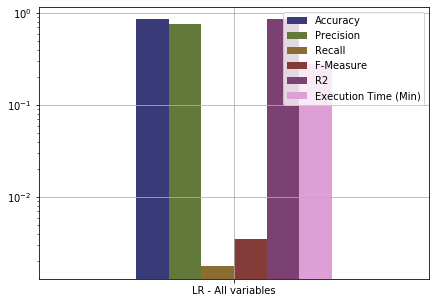

In [24]:
labels = ["Input","Accuracy","Precision","Recall","F-Measure","R2","Execution Time (Min)"]
results = []
results.append(["LR - All variables", accuracy_lr_all, precision_lr_all, recall_lr_all, fmeasure_lr_all, score_lr_all, (exec_time_lr_all/60)])
# results.append(["LR - Selected variables", accuracy_lr_sel, precision_lr_sel, recall_lr_sel, fmeasure_lr_sel, score_lr_sel, (exec_time_lr_sel/60)])

df_results_lr = pd.DataFrame.from_records(results, columns=labels)
print(df_results_lr)

plot_results(df_results_lr, "results_comparison_lr_500000_w0.png")

In [25]:
df_results_lr

,Input,Accuracy,Precision,Recall,F-Measure,R2,Execution Time (Min)
0,LR - All variables,0.856296,0.7625,0.001766,0.003523,0.856296,0.279929


Why is logistic regression better than random forest? In this method we represented our data with a huge amount of features. Having many features we need a very simple classifier in order to not overfit the data. Logistic regression is way more simple than random forest. Moreover, the sparsity of the data makes it very hard for the random forest to find good splits that will help in separating the classes.